In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import plotting
from pathlib import Path
import auxiliary
#from MCMC_affine_multi import run_MCMC as run
from MCMC_aux import get_model
import os
import scipy.interpolate as interp
import mass_calc as mc
import matplotlib
import Parameters as par
import Models as mod
import Kernels as ker
import GP_Likelihood as gp
from MCMC import run_MCMC as run
import new_plotting as plot
from saving import save
%matplotlib inline

2813.2308006313287 16620.585819951895


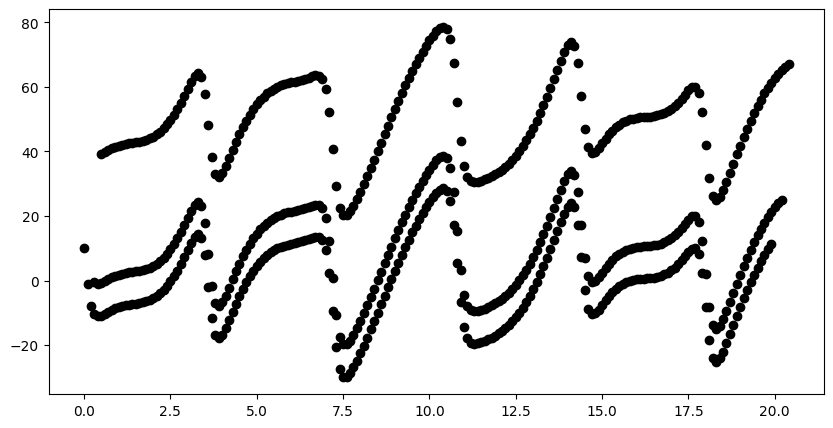

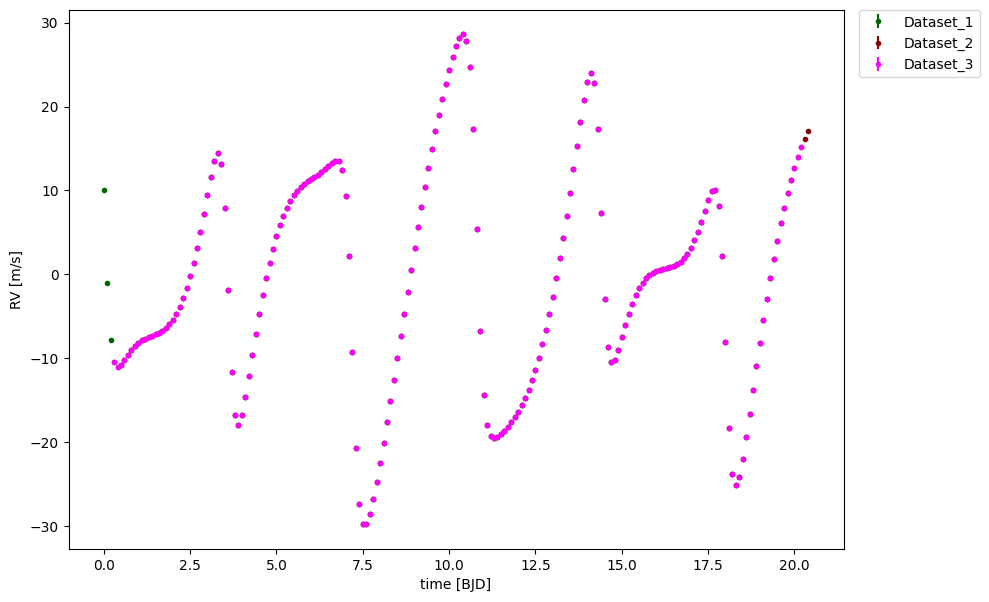

In [2]:
def ecc_anomaly(M, ecc, max_itr=200):
    '''
    ----------
    M : float
        Mean anomaly
    ecc : float
        Eccentricity, number between 0. and 0.99
    max_itr : integer, optional
        Number of maximum iteration in E computation. The default is 200.
    Returns
    -------
    E : float
        Eccentric anomaly
    '''
    
    E0 = M
    E = M
    #print("E before = ", E)
    for i in range(max_itr):
        f = E0 - ecc*np.sin(E0) - M
        fp = 1. - ecc*np.cos(E0)
        E = E0 - f/fp
        
        # check for convergence
        if (np.linalg.norm(E - E0, ord=1) <= 1.0e-10):
            return E
            break
        # if not convergence continue
        E0 = E
    
    # no convergence, return best estimate
    #print('Best estimate E = ',E[0:5])
    return E

time1 = np.arange(0., 20., 0.1)
A = 10.
P = 5.
Aerr = []
Perr = []
Rerr = []
Keperr = []
for i in time1:
    Aerr.append(A+np.random.uniform(0,0))
    Perr.append(2*np.pi/(P+np.random.uniform(0,0)))
    Rerr.append(np.random.uniform(0,0))
    Keperr.append(np.random.uniform(-3,3))

y1 = Aerr*np.cos(time1*(Perr))+Rerr
y1_err = np.ones_like(y1)*0.01

time2 = np.arange(0.5,20.5,0.1)
y2 = Aerr*np.cos(time2*(Perr))+Rerr+50
y2_err = np.ones_like(y2)*0.5

time3 = np.arange(0.3,20.3,0.1)
y3 = Aerr*np.cos(time3*(Perr))+Rerr+10
y3_err = np.ones_like(y3)*0.5

time, y, y_err, flags = mod.combine_data([time1,time2,time3], (y1,y2,y3), (y1_err,y1_err,y1_err))
#print(flags)


fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(1,1,1)
#ax.scatter(time,y, c="k")
#plt.show()
#ax.plot(time, y ,c="r")

K = 20
ecc = 0.5
omega = np.pi/2.
Pl = 3.6
t0 = time[0]

M = 2*np.pi * (time-t0) / Pl
E = ecc_anomaly(M, ecc)
nu = 2. * np.arctan(np.sqrt((1.+ecc)/(1.-ecc)) * np.tan(E/2.))

Kep = K * (np.cos(omega + nu) + ecc*np.cos(omega))
y = y + Kep

#K = 15
#ecc = 0.7
#omega = np.pi/4
#Pl = 1.2
#t0 = time[0]

#M = 2*np.pi * (time-t0) / Pl
#E = ecc_anomaly(M, ecc)
#nu = 2. * np.arctan(np.sqrt((1.+ecc)/(1.-ecc)) * np.tan(E/2.))

#Kep2 = K * (np.cos(omega + nu) + ecc*np.cos(omega))
#y += Kep2
#fig = plt.figure(figsize = (10,5))
#ax = fig.add_subplot(1,1,1)
ax.scatter(time,y, c="k")
#plt.show()
#ax.errorbar(time, y, yerr = y_err, fmt = '.', color = 'k')
plot.data_plot(time, y, y_err = y_err, flags = flags, offsets = [50,10])

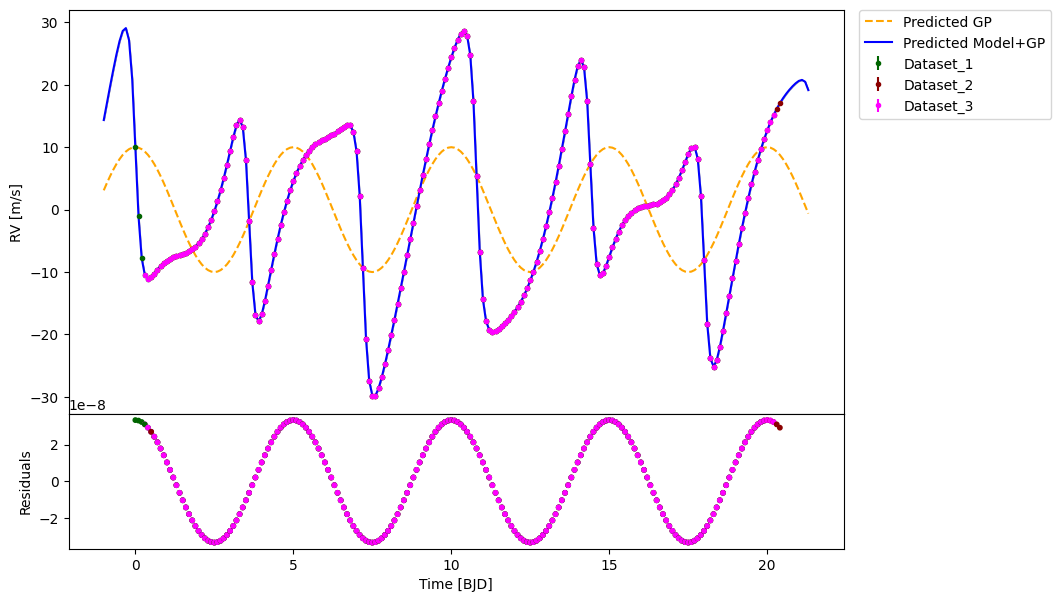

In [3]:
iterations = 10
numb_chains = 30
hparam = par.par_create("Cosine")
hparam["gp_amp"] = par.parameter(value = 10., error = 0.5, vary = True)
hparam["gp_per"] = par.parameter(value = 5., error = 0.5, vary = True)
prior_list = []
pri_amp = par.pri_create("gp_amp", "Uniform", [5.,15.])
prior_list.append(pri_amp)
pri_per = par.pri_create("gp_per", "Uniform", [0.,10.])
prior_list.append(pri_per)

model_list = ["Keplerian", "Offset", "Offset"]
model_par = mod.mod_create(model_list)

model_par["P_0"]=par.parameter(value=3.6, error=0.5, vary=True)
model_par["K_0"]=par.parameter(value=20., error=1., vary=True)
model_par["ecc_0"]=par.parameter(value=0.5, error=0.1, vary=True)
model_par["omega_0"]=par.parameter(value=np.pi/2, error=0.05, vary=True)
model_par["t0_0"]=par.parameter(value=0., error=10., vary=True)
#model_par["P_1"]=par.parameter(value=1.2, error=0.5, vary=True)
#model_par["K_1"]=par.parameter(value=15., error=1., vary=True)
#model_par["ecc_1"]=par.parameter(value=0.7, error=0.1, vary=True)
#model_par["omega_1"]=par.parameter(value=np.pi/4, error=0.05, vary=True)
#model_par["t0_1"]=par.parameter(value=0., error=10., vary=True)
model_par["offset_0"] = par.parameter(50., 0.5, True) # applied to np.zeros + 1 (2nd item in get_data times list)
model_par["offset_1"] = par.parameter(10., 0.5, True) # applied ot np.zeros + 2 (3rd item in get_data times list)
#model_y = get_model(model_list, time, model_par, to_ecc=False)

#pri_per = par.pri_create("P_0", "Uniform", [0.,5.])
#prior_list.append(pri_per)
#pri_per = par.pri_create("K_0", "Uniform", [10.,30.])
#prior_list.append(pri_per)
#pri_per = par.pri_create("ecc_0", "Uniform", [0.,1.])
#prior_list.append(pri_per)
#pri_per = par.pri_create("t0_0", "Uniform", [0.,5.])
#prior_list.append(pri_per)
pri_per = par.pri_create("offset_0", "Uniform", [40.,60.])
prior_list.append(pri_per)
pri_per = par.pri_create("offset_1", "Uniform", [0.,20.])
prior_list.append(pri_per)
#pri_per = par.pri_create("P_1", "Uniform", [0.,5.])
#prior_list.append(pri_per)
#pri_per = par.pri_create("K_1", "Uniform", [10.,30.])
#prior_list.append(pri_per)
#pri_per = par.pri_create("ecc_1", "Uniform", [0.,1.])
#prior_list.append(pri_per)
#pri_per = par.pri_create("t0_1", "Uniform", [0.,5.])
#prior_list.append(pri_per)

#loglik = gp.GPLikelihood(time, y, y_err, hparam, "Cosine", model_y, model_par)
#logL = loglik.LogL(prior_list)
xpred = np.arange(time[0]-1., time[-1]+1., 0.001)
#GP_y, GP_err = loglik.predict(xpred)

#plt.figure(figsize=(10,5))
#plt.scatter(time,y, c="k")
#plt.plot(time,model_y, c="b")
#plt.plot(xpred,GP_y,c="r")
plot.GP_plot(time, y, hparam, "Cosine", y_err, model_list = model_list, model_param = model_par, flags = flags, residuals = True)
#plot.keplerian_only_plot(time, y, hparam, "Cosine", model_list, model_par, y_err, flags = flags, keplerian_number = 0, residuals = True)
#plot.keplerian_only_plot(time, y, hparam, "Cosine", model_list, model_par, y_err, keplerian_number = 1, residuals = True)
#plot.phase_plot(time, y, hparam, "Cosine", model_list, model_par, y_err, flags = flags, keplerian_number = 0, residuals = True)

In [4]:
logL_chain, fin_hparams, fin_model_param, completed_iterations, masses = run(iterations, time, y, y_err, hparam, "Cosine", model_par, model_list, prior_list, numb_chains=numb_chains, flags = flags, Mstar = 1)


Initial hyper-parameter guesses: 
[10.0, 5.0]

Initial model parameter guesses (ecc and omega are replaced by Sk and Ck): 
[3.6, 20.0, 0.7071067811865476, 4.329780281177467e-17, 0.0, 50.0, 10.0]

Initial Log Likelihood:  2191.719698617626

Number of chains:  30

Start Iterations

Progress:  |██████████████████████████████████████████████████| 100.0% Complete


10 iterations have been completed with 30 contemporaneous chains

162 168
Acceptance Rate =  0.4909090909090909
 ---- 0.15819441477457682 minutes ----


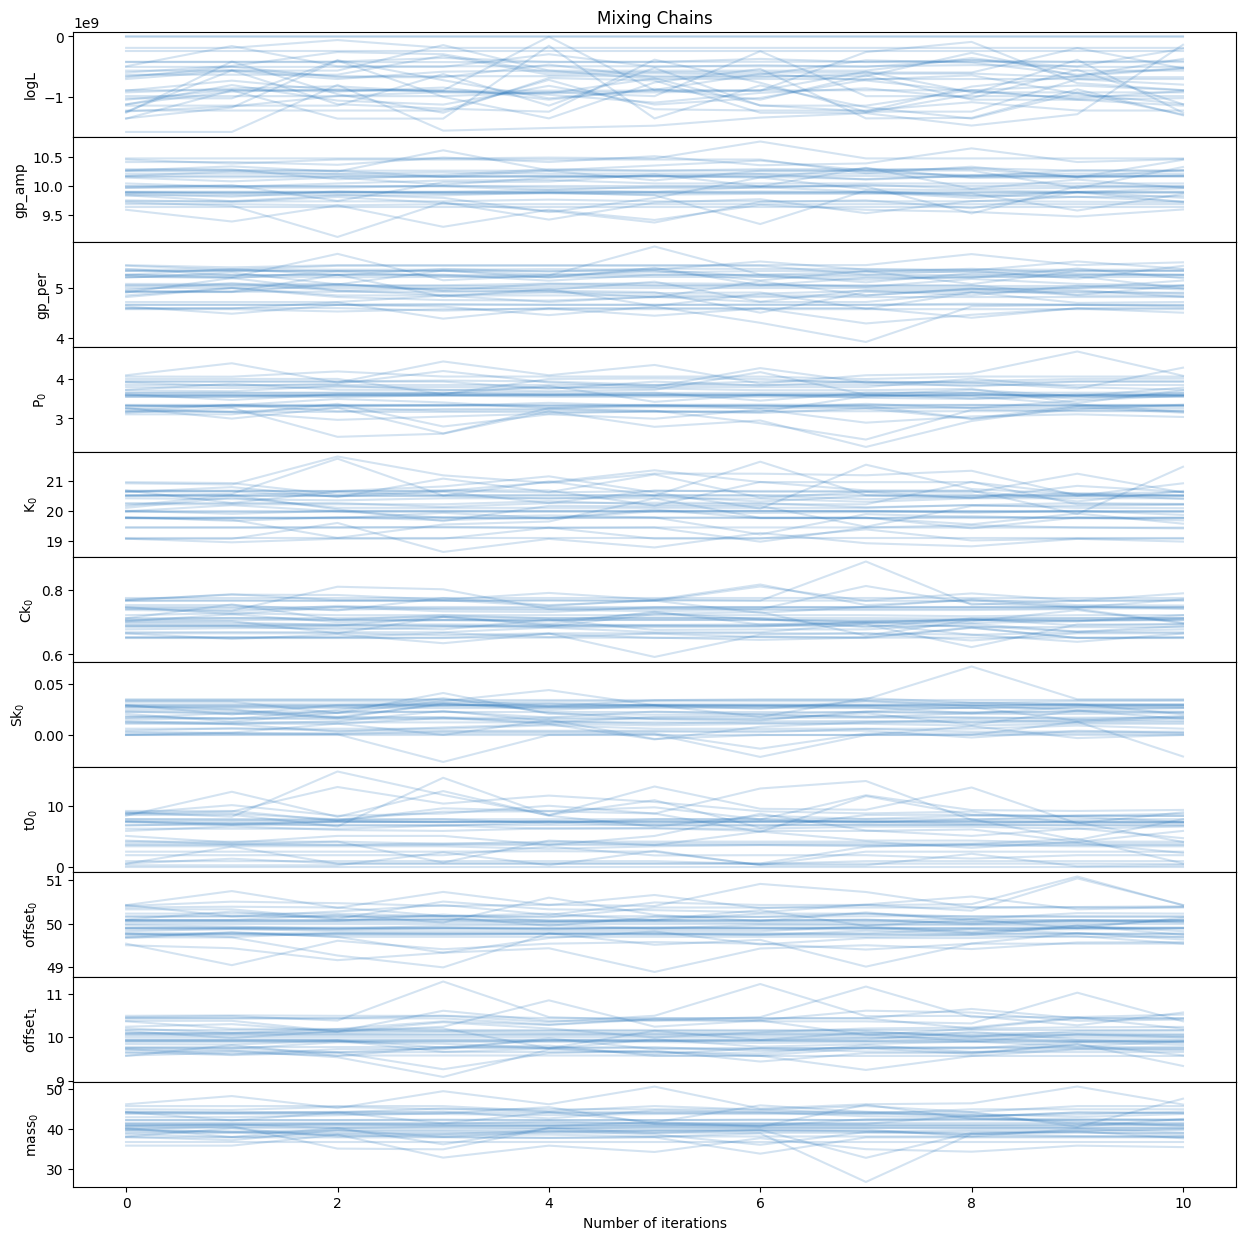

In [5]:
#print(np.shape(logL_chain))
#print(fin_hparams)
#print(np.shape(fin_model_param))
#print(masses)

plot.mixing_plot(fin_hparams, "Cosine", fin_model_param, model_list, logL_chain, masses)

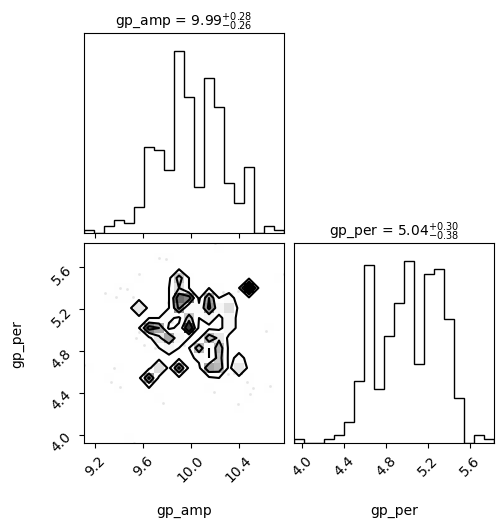

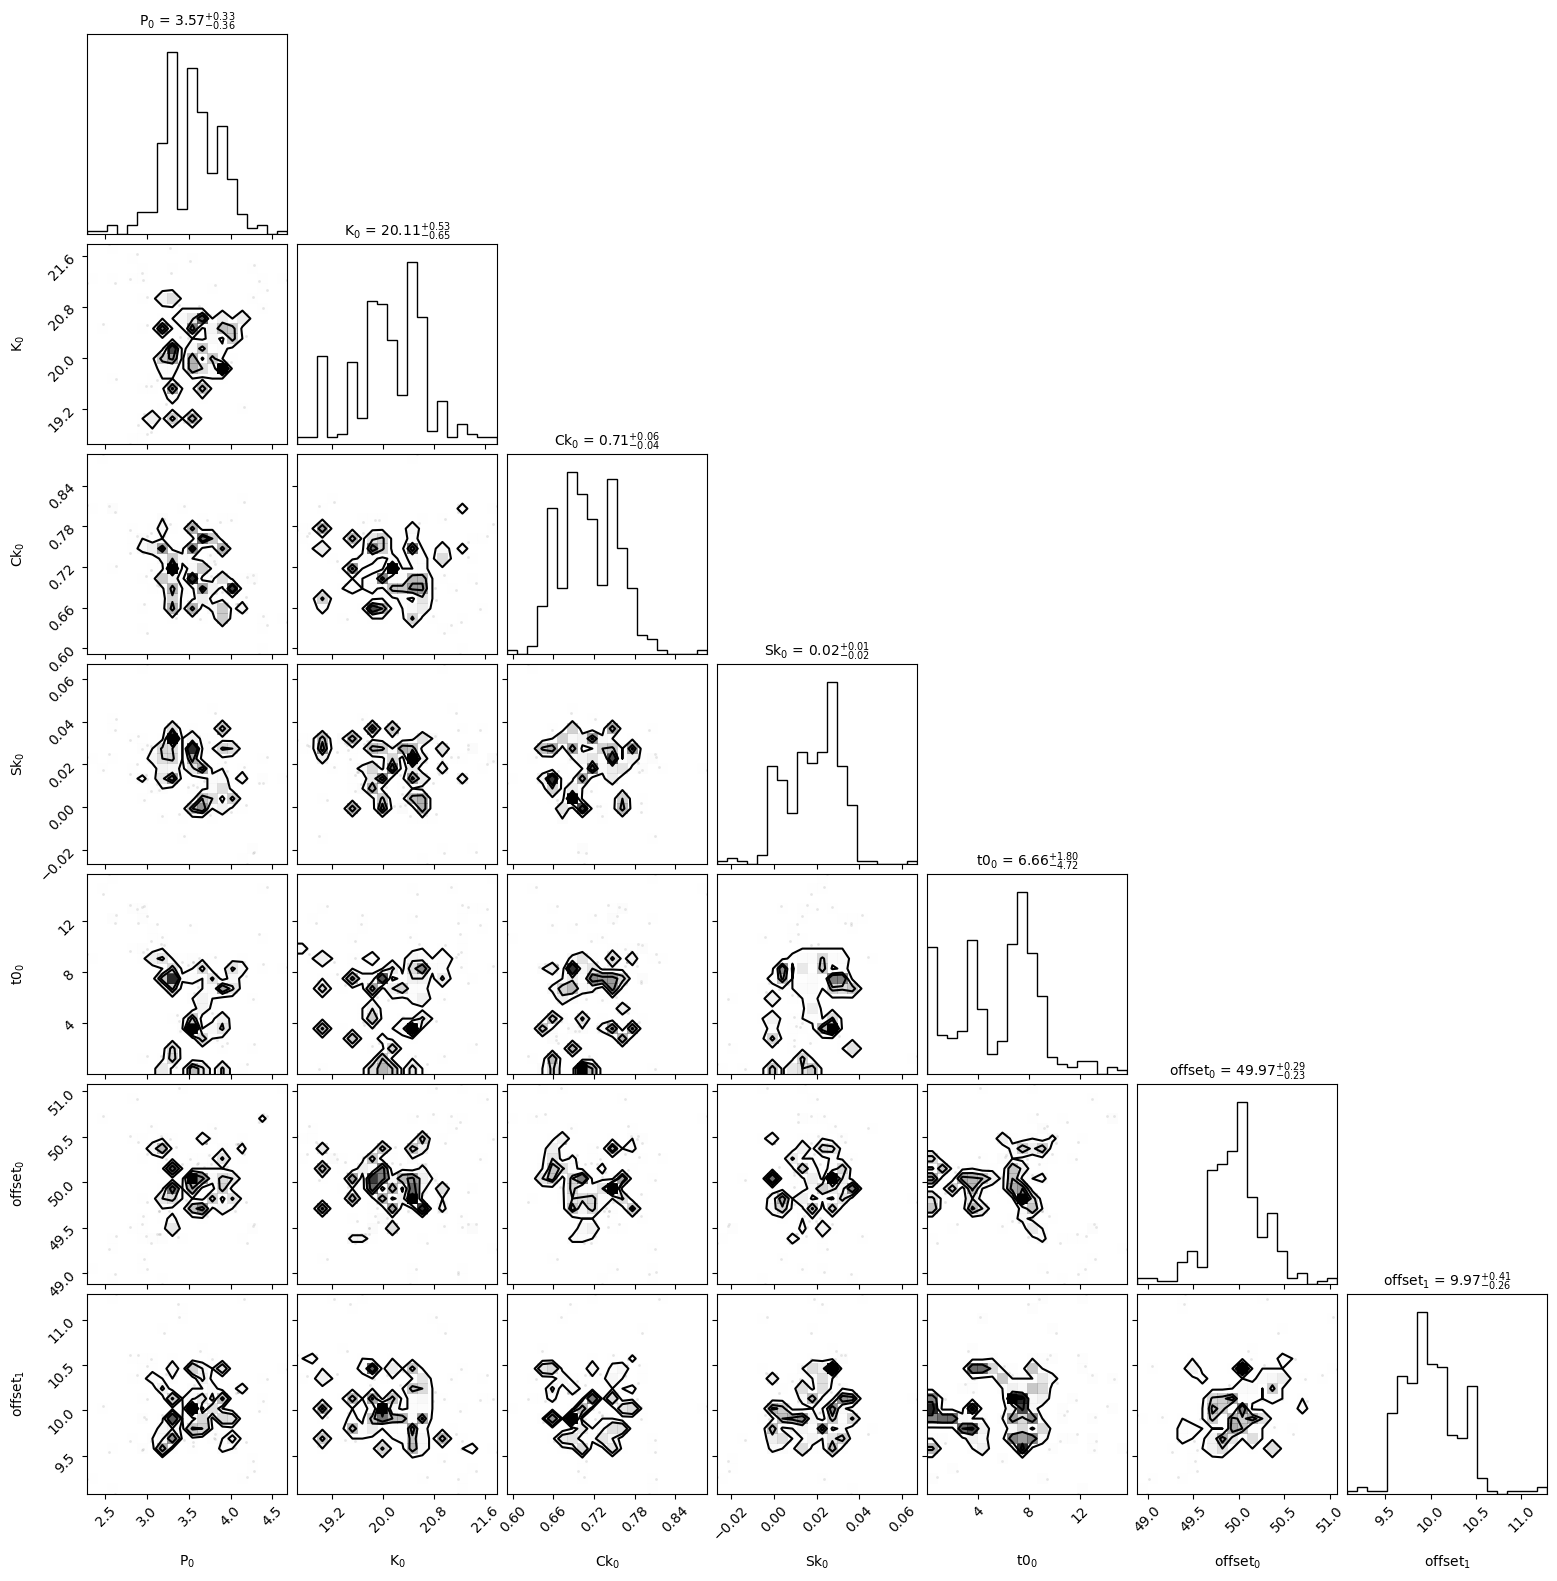

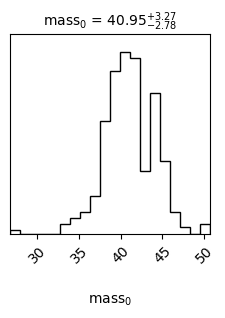

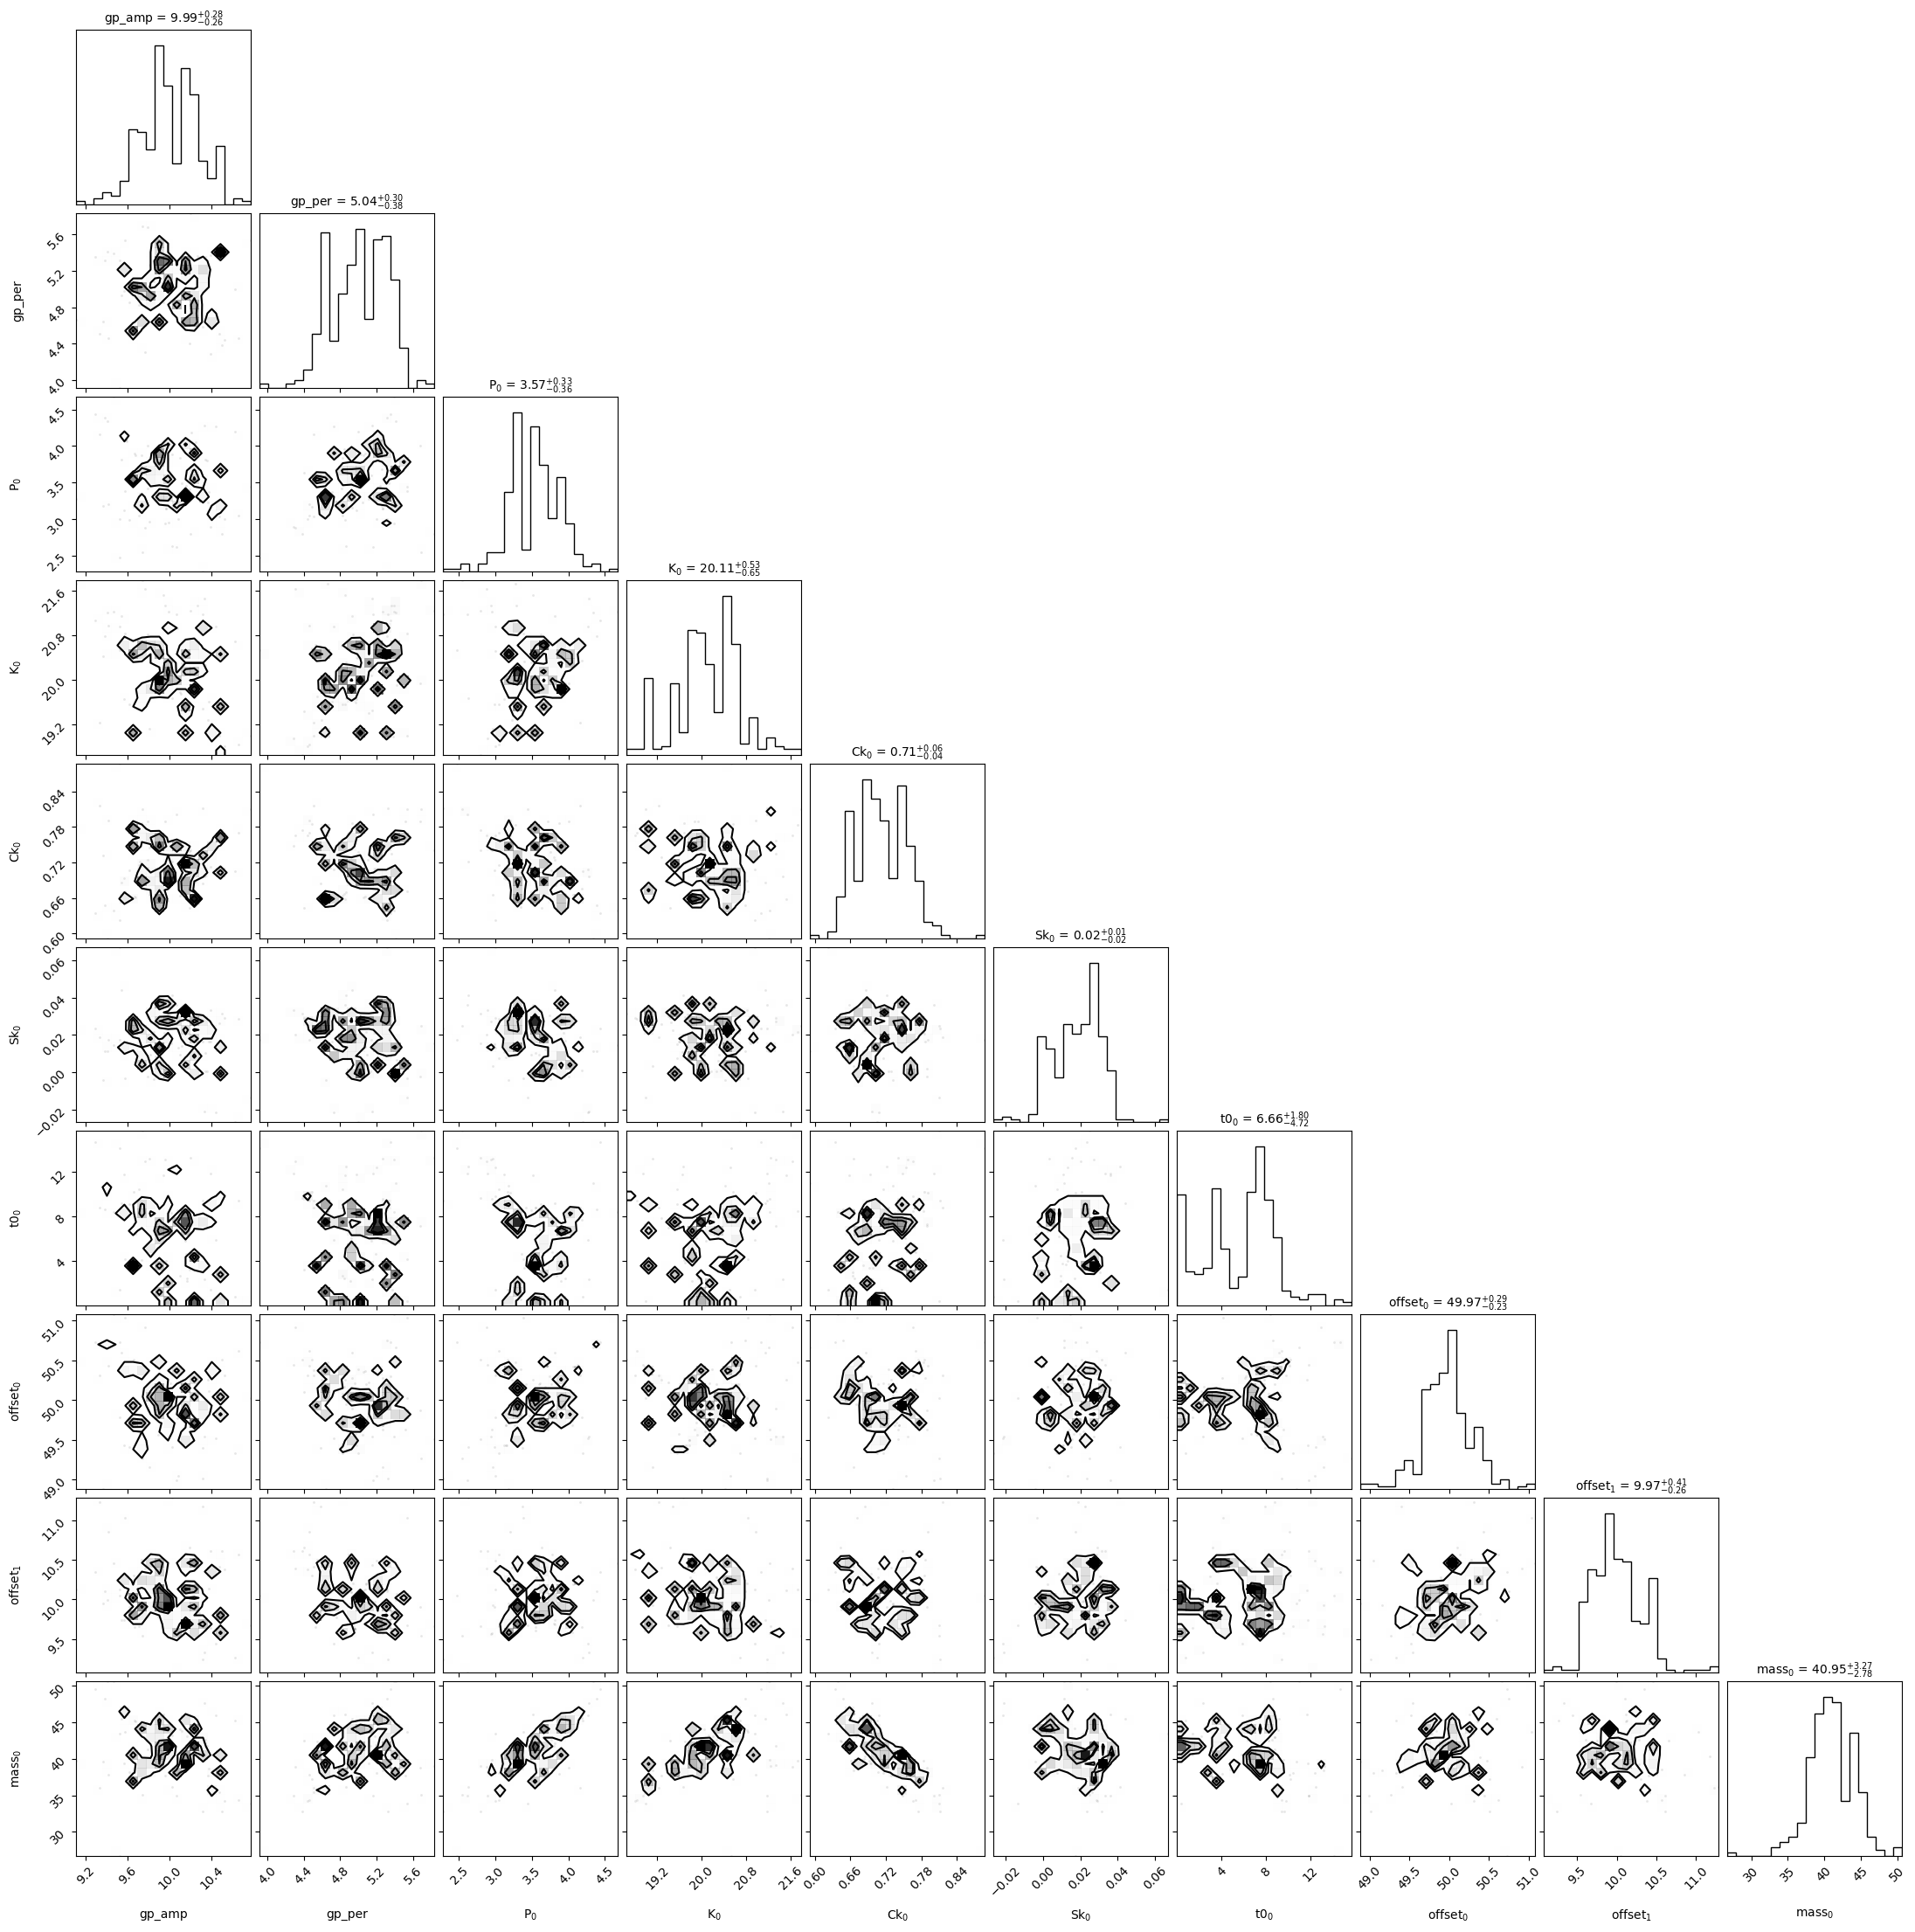

Parameter values after MCMC:  [9.990846543714717, 5.04231755102405, 3.5740426786590787, 20.105042961677878, 0.7071354140809771, 0.020249403979659488, 6.6580748712844136, 49.96693632370654, 9.970998046774627, 40.95044835818955]


In [6]:
final_param_values, final_param_erru, final_param_errd = plot.corner_plot(fin_hparams, "Cosine", fin_model_param, model_list, masses, errors=True)

In [7]:
save('/Users/bdixon/Desktop/MAGPy/Data', y, time, y_err, model_list = model_list, init_param = model_par, flags = flags, kernel = 'Cosine', init_hparam = hparam, prior_list = prior_list, fin_hparam_post = fin_hparams, fin_param_post = fin_model_param, logl_chain = logL_chain, masses = masses)